# Analysing Results

In [1]:
import gzip
import os

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

import lcdb.json

from lcdb.analysis import read_csv_results
from lcdb.analysis import hyperparameters_from_row
from lcdb.analysis.plot import plot_learning_curves
from lcdb.analysis.plot import plot_regret_from_topk

# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues
from lcdb.analysis.json import QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryAnchorKeys
from lcdb.analysis.json import QueryEpochValues
from lcdb.analysis.json import QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix
from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix

update_matplotlib_rc()
figsize = figure_size(252 * 1.0, 1.0)

In [2]:
# with all anchors: 3, 6, 14, 16,
# with last anchor: 1464,
openml_id = 1464

# Loads the data of constant (i.e., predicting the mode of the prior distribution P(Y))
source_constant = f"../constant/output/lcdb.workflow.sklearn.ConstantWorkflow/{openml_id}/0-0-0/output.json.gz"

with gzip.GzipFile(source_constant, "rb") as f:
    json_constant = lcdb.json.loads(f.read())

In [3]:
source_csv = f"output/lcdb.workflow.keras.DenseNNWorkflow/{openml_id}/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
81,relu,none,False,32,none,0.100000,glorot_uniform,none,0.001000,5,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
447,softmax,none,False,84,L1L2,0.812562,he_normal,L2,0.004080,19,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
780,selu,L1,False,6,none,0.659186,glorot_normal,none,0.000012,20,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
355,none,none,False,255,none,0.331280,random_uniform,L2,0.001910,14,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
47,softmax,none,True,25,none,0.712909,glorot_uniform,L1L2,0.409982,7,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,relu,none,True,34,none,0.840831,random_normal,L1,0.007336,2,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
758,softsign,L1L2,False,2,L2,0.790696,zeros,L1L2,0.712537,9,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
759,softsign,L1,False,97,L1L2,0.318201,he_uniform,L2,0.064079,10,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
704,none,none,True,42,none,0.454097,he_uniform,L2,0.000895,10,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [4]:
r_df_failed

,p:activation,p:activity_regularizer,p:batch_norm,p:batch_size,p:bias_regularizer,p:dropout_rate,p:kernel_initializer,p:kernel_regularizer,p:learning_rate,p:num_layers,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
1,exponential,L1,True,2,L1L2,0.663961,ones,L1,7.503509,18,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
2,softplus,L1L2,False,5,none,0.626869,glorot_uniform,L1,2.706177,9,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
4,exponential,L1,True,287,L2,0.066666,he_normal,L1,8.208794,2,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
5,exponential,L1,False,484,none,0.587300,random_normal,L2,0.360132,5,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
6,exponential,L1L2,False,208,L1,0.182733,truncated_normal,L2,0.002753,3,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,exponential,L1L2,True,2,none,0.786694,orthogonal,L1,2.320171,14,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
855,exponential,L2,False,19,L1L2,0.805702,variance_scaling,L1L2,0.010972,15,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
857,softplus,L1L2,True,3,none,0.441701,random_normal,L1,0.072566,18,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
906,exponential,L2,True,67,L1,0.584464,zeros,L2,0.106679,9,...,1464,42,lcdb.workflow.keras.DenseNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [5]:
print("Number of successful runs:", len(r_df))
print("Number of failed runs:", len(r_df_failed))

timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Number of successful runs: 872
Number of failed runs: 124
Experiment duration: 1083.5904273986816 seconds


In [6]:
# Display the error of a failed job
idx = 0
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 211, in fit_workflow_on_current_anchor
    self.workflow.fit(
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/utils.py", line 67, in terminate_on_timeout
    return results.get(timeout)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 774, in get
    raise self._value
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/build/dhenv/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/workflow/_base_workflow.py", line 31, in fit
    self._fit(X=X, y=y, metadata=metadata, *args, **kwargs)
  File "/lus/grand/projects/datascience/regele/po

## Validation Error Rate vs. Number of Samples

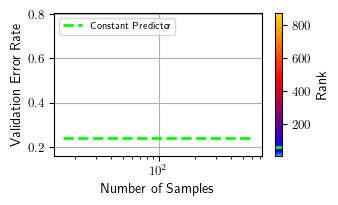

In [7]:
# Plot: Validation Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    anchor_values[i] = xi[: len(yi)]


anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
error_rate_constant_predictor = list(
    map(
        lambda x: 1 - accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    error_rate_values,
    ax=ax,
    metric_value_baseline=error_rate_constant_predictor[-1],
)
ax.plot(
    anchor_values_constant_predictor,
    error_rate_constant_predictor,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
ax.legend()
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [76]:
def infer_topk_from_scores(y, tolerance=1e-2):
    y = np.asarray(y)
    y_star = np.min(y)
    y = y[np.abs(y_star - y) <= tolerance]
    topk = len(y)
    return topk, (np.min(y), np.max(y))

Inferred Topk: 6
Min: 0.0031250000000000444, Max: 0.018750000000000044


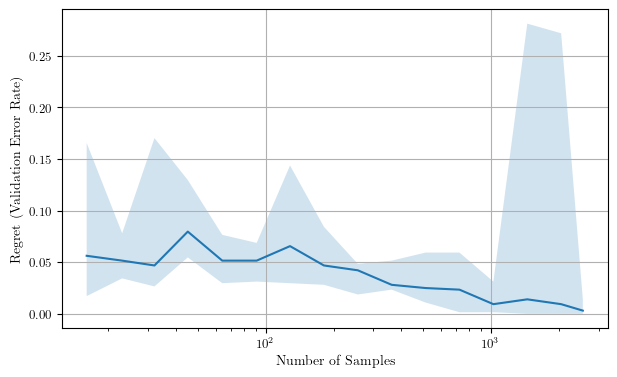

In [77]:
tolerance = 2e-2
topk, (y_min, y_max) = infer_topk_from_scores(list(map(lambda x: x[-1], error_rate_values)), tolerance=tolerance)
print(f"Inferred Topk: {topk}")
print(f"Min: {y_min}, Max: {y_max}")

fig, ax = plt.subplots(figsize=figsize)
plot_regret_from_topk(anchor_values, error_rate_values, topk=topk, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Regret (Validation Error Rate)")
ax.set_xscale("log")
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), f"regret_top{topk}_tol{tolerance}_val_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

Inferred Topk: 6
Max: 0.996875 - Min: 0.98125


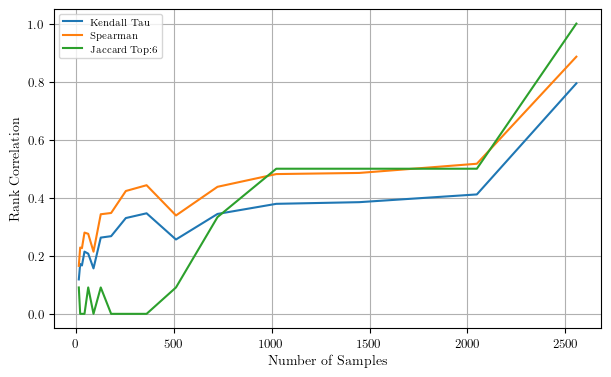

In [78]:
def pad_with_last(x, max_len):
    if len(x) < max_len:
        return x + [x[-1]] * (max_len - len(x))
    else:
        return x

max_len = max(map(len, error_rate_values))
error_rate_values = list(map(lambda x: pad_with_last(x, max_len), error_rate_values))
error_rate_values = np.array(error_rate_values)
y_star = error_rate_values[:,-1].min(axis=0)

for x in anchor_values:
    if len(x) == max_len:
        break

import scipy.stats as ss
from deephyper.analysis import rank

rank_values = rank(error_rate_values, method="ordinal", axis=0)
kendalltau_rank_correlation = lambda x: ss.kendalltau(x, rank_values[:,-1]).statistic
spearman_rank_correlation = lambda x: ss.spearmanr(x, rank_values[:,-1]).statistic
kendalltau_correlation_values = list(map(kendalltau_rank_correlation, error_rate_values.T))
spearman_correlation_values = list(map(spearman_rank_correlation, error_rate_values.T))

plt.figure(figsize=figsize)
plt.plot(x, kendalltau_correlation_values, label="Kendall Tau")
plt.plot(x, spearman_correlation_values, label="Spearman")

accepted_error = 2e-2
y_select = error_rate_values[:,-1]
y_select = y_select[np.abs(y_star - y_select) < accepted_error]
topk = len(y_select)
print(f"Inferred Topk: {topk}")
print(f"Max: {1-np.min(y_select)} - Min: {1-np.max(y_select)}")

# topk = 100
idx_sorted_rank_max_fidelity = np.argsort(rank_values[:,-1])
# score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / topk
score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / len(np.union1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk]))
score_values = list(map(score, rank_values.T))
plt.plot(x, score_values, label=f"Jaccard Top:{topk}")

plt.xlabel("Number of Samples")
plt.ylabel("Rank Correlation")
plt.grid()
plt.legend()
plt.show()

## Validation Error Rate vs. Time

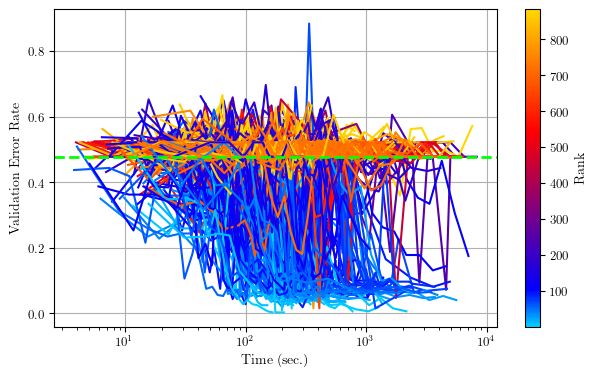

In [79]:
# Plot: Validation Error Rate vs. Time
source = r_df["m:json"]

query_anchor_timestamp_stop = QueryAnchorKeys("timestamp_stop")
timestamp_stop_values = source.apply(query_anchor_timestamp_stop).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(timestamp_stop_values, error_rate_values)):
    timestamp_stop_values[i] = xi[: len(yi)]


timestamp_stop_values_constant_predictor = query_anchor_timestamp_stop(
    json_constant["metadata"]["json"]
)
error_rate_constant_predictor = list(
    map(
        lambda x: 1 - accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    timestamp_stop_values,
    error_rate_values,
    metric_value_baseline=error_rate_constant_predictor[-1],
    ax=ax,
)
ax.axhline(
    # timestamp_stop_values_constant_predictor,
    error_rate_constant_predictor[-1],
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Time (sec.)")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
# ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_time.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Validation Balanced Error Rate vs. Number of Samples

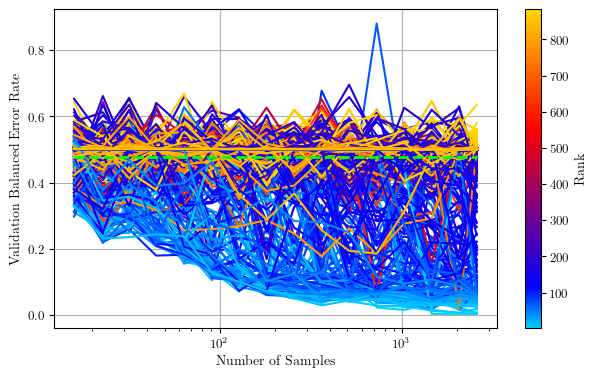

In [80]:
# Plot: Validation Balanced Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
balanced_error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, balanced_error_rate_values)):
    anchor_values[i] = xi[: len(yi)]

anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
balanced_error_rate_constant_predictor = list(
    map(
        lambda x: 1 - balanced_accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    balanced_error_rate_values,
    metric_value_baseline=balanced_error_rate_constant_predictor[-1],
    ax=ax,
)
ax.plot(
    anchor_values_constant_predictor,
    error_rate_constant_predictor,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Balanced Error Rate")
ax.set_xscale("log")
# ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_samples.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Validation Balanced Error Rate vs. Number of Epochs

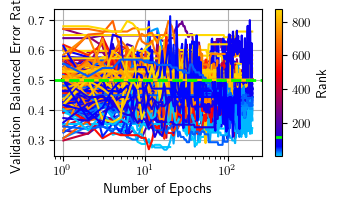

In [9]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
balanced_error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
).to_list()

anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
balanced_error_rate_constant_predictor = list(
    map(
        lambda x: 1 - balanced_accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

# Remove experiments which ended up with "NaN"
epoch_values, balanced_error_rate_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, balanced_error_rate_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    epoch_values,
    balanced_error_rate_values,
    metric_value_baseline=balanced_error_rate_constant_predictor[-1],
    ax=ax,
)
ax.axhline(
    balanced_error_rate_constant_predictor[-1],
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation Balanced Error Rate")
ax.set_xscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_epochs.jpg"), dpi=300, bbox_inches="tight")
plt.show()

Inferred Topk: 6
Min: 0.006261985832257011, Max: 0.02232789323314155


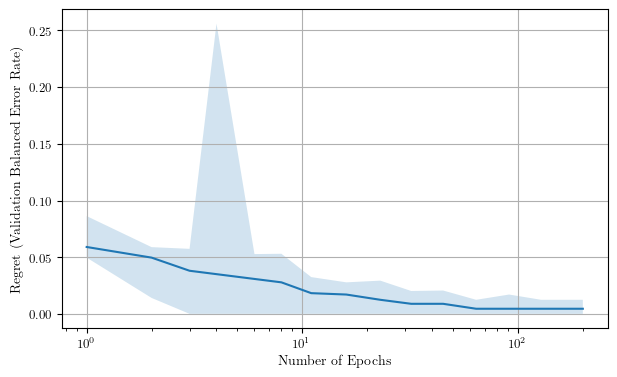

In [82]:
tolerance = 2e-2
y = []
for yi in balanced_error_rate_values:
    y.append(yi[-1])
topk, (y_min, y_max) = infer_topk_from_scores(y, tolerance=tolerance)
print(f"Inferred Topk: {topk}")
print(f"Min: {y_min}, Max: {y_max}")

fig, ax = plt.subplots(figsize=figsize)
plot_regret_from_topk(epoch_values, balanced_error_rate_values, topk=topk, ax=ax)
ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Regret (Validation Balanced Error Rate)")
ax.set_xscale("log")
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), f"regret_top{topk}_tol{tolerance}_val_balanced_error_rate_vs_epochs.jpg"), dpi=300, bbox_inches="tight")
plt.show()

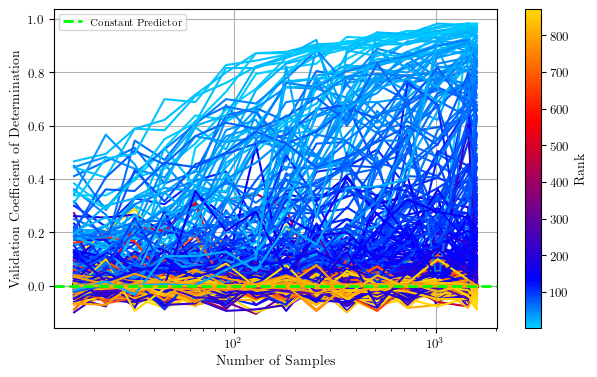

In [14]:
# Plot: Validation Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    anchor_values[i] = xi[: len(yi)]

anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
error_rate_constant_predictor = list(
    map(
        lambda x: 1 - accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    error_rate_values[i] = (1 - np.asarray(yi) / np.asarray(error_rate_constant_predictor[:len(yi)])).tolist()

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    error_rate_values,
    mode="max",
    ax=ax,
    metric_value_baseline=0.0,
)
ax.axhline(
    0.0,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Coefficient of Determination")
ax.set_xscale("log")
ax.legend()
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_r2_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

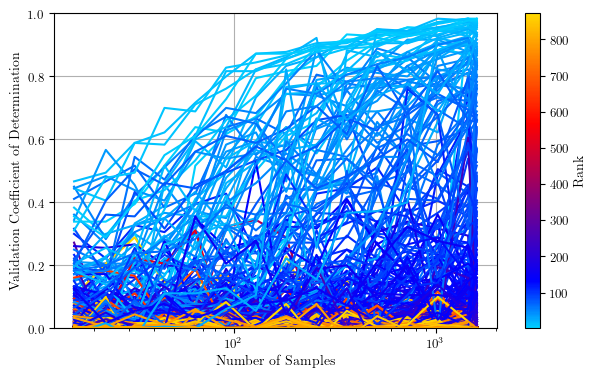

In [19]:
# Plot: Validation Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    anchor_values[i] = xi[: len(yi)]

anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
error_rate_constant_predictor = list(
    map(
        lambda x: 1 - accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    error_rate_values[i] = (1 - np.asarray(yi) / np.asarray(error_rate_constant_predictor[:len(yi)])).tolist()

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    error_rate_values,
    mode="max",
    ax=ax,
    metric_value_baseline=0.0,
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Coefficient of Determination")
ax.set_xscale("log")
ax.set_ylim(0.0, 1.0)
# ax.legend()
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_r2_vs_samples_01.jpg"), dpi=300, bbox_inches="tight")
plt.show()

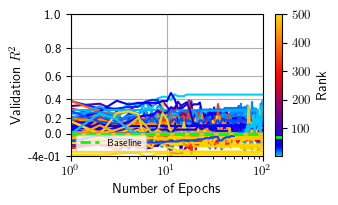

In [10]:
source = r_df["m:json"]

# Query All Epochs and Keep Only Last Anchor
query_epoch_values = QueryEpochValues()
epoch_values = source.apply(lambda x: query_epoch_values(x)[-1]).to_list()

query_confusion_matrix_values = QueryMetricValuesFromEpochs(
    "confusion_matrix", split_name="val"
)
out = source.apply(lambda x: query_confusion_matrix_values(x)[-1])
balanced_error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
).to_list()

query_anchor_values = QueryAnchorValues()
anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
balanced_error_rate_constant_predictor = list(
    map(
        lambda x: 1 - balanced_accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

# Remove experiments which ended up with "NaN"
epoch_values, balanced_error_rate_values = list(
    zip(
        *[
            (xi, yi)
            for xi, yi in zip(epoch_values, balanced_error_rate_values)
            if len(xi) == len(yi) and len(xi) > 0
        ]
    )
)
epoch_values = list(epoch_values)
balanced_error_rate_values = list(balanced_error_rate_values)

for i, (xi, yi) in enumerate(zip(epoch_values, balanced_error_rate_values)):
    xi = np.array(xi)
    xi = xi[xi <= 100].tolist()
    yi = (1 - np.asarray(yi) / balanced_error_rate_constant_predictor[-1])
    yi = yi[:len(xi)].tolist()

    xi = xi + [100]
    yi = yi + [yi[-1]]

    epoch_values[i] = xi
    balanced_error_rate_values[i] = yi

random_state = 42
rs = np.random.RandomState(random_state)
# num_models = len(keys) 
num_models = 500
selection = rs.choice(np.arange(len(epoch_values)), size=num_models, replace=False)

epoch_values_ = epoch_values
balanced_error_rate_values_ = balanced_error_rate_values
epoch_values = []
balanced_error_rate_values = []
for i, (xi, yi) in enumerate(zip(epoch_values_, balanced_error_rate_values_)):
    if i in selection:
        epoch_values.append(xi)
        balanced_error_rate_values.append(yi)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    epoch_values,
    balanced_error_rate_values,
    metric_value_baseline=0.0,
    mode="max",
    ax=ax,
)
ax.axhline(
    0.0,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Baseline",
)

x_min = min(map(min, balanced_error_rate_values))
def forward(x):
    x = np.exp(x) 
    return x

def inverse(x):
    x = np.log(x)
    return x

ax.set_xlabel(f"Number of Epochs")
ax.set_ylabel(f"Validation $R^2$")
ax.legend(loc="lower left")
ax.set_xscale("log")
ax.set_yscale("function", functions=(forward, inverse))
ax.set_xlim(1,100)
ax.set_ylim(x_min, 1.0)
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([x_min, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([f"{x_min:.0e}", "0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]))
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_r2_vs_epochs_01.jpg"), dpi=300, bbox_inches="tight")
plt.show()